In [1]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = '0'  # using specific GPU
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.logging.set_verbosity(tf.logging.ERROR)

from compatible.likelihoods import MultiClass, Gaussian
from compatible.kernels import RBF, White
from gpflow.models.svgp import SVGP
from gpflow.training import AdamOptimizer, ScipyOptimizer
from scipy.stats import mode
from scipy.cluster.vq import kmeans2
import gpflow
from gpflow.mean_functions import Identity, Linear
from gpflow.mean_functions import Zero
from gpflow import autoflow, params_as_tensors, ParamList
import pandas as pd
import itertools
pd.options.display.max_rows = 999
import gpflow_monitor

from scipy.cluster.vq import kmeans2
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.io import loadmat
from gpflow_monitor import *
print('tf_ver:', tf.__version__, 'gpflow_ver:', gpflow.__version__)
from tensorflow.python.client import device_lib
print('avail devices:\n'+'\n'.join([x.name for x in device_lib.list_local_devices()]))
from jack_utils.common import time_it
import sys
import gpflow.training.monitor as mon

# our impl
from dgp_graph import *

tf_ver: 1.15.0 gpflow_ver: 1.5.0
avail devices:
/device:CPU:0
/device:XLA_CPU:0
/device:XLA_GPU:0


Using TensorFlow backend.


In [2]:
plt.rcParams['figure.dpi'] = 100
np.random.seed(123456)

In [3]:
cc=50
loc=60
tts=200
inc=False
M = 5

nss=0

# build data

1 2-3 4-5-6

1-2 3-4 5-6

In [4]:
nodes=6
ndata=200

data=np.zeros((ndata+1, nodes))

tns=0.1

In [5]:
data[:100, 0]=np.random.rand(100)
data[:100, 1]=np.random.rand(100)
data[1:100+1, 2]=data[:100, 1]*2 + tns*np.random.rand(100)
data[:100, 3]=np.random.rand(100)
data[1:100+1, 4]=data[:100, 3]*0.5 + tns*np.random.rand(100)
data[1:100+1, 5]=data[:100, 4]+data[:100, 3] + tns*np.random.rand(100)

In [6]:
data[100:, 0]=np.random.rand(100+1)
data[100+1:, 1]=data[100:200, 0]*2 + tns*np.random.rand(100)
data[100+1:, 2]=data[100:200, 0]*0.7 + tns*np.random.rand(100)
data[100+1:, 3]=-0.5*data[100:200, 0] + tns*np.random.rand(100)
data[100:, 4]=np.random.rand(100+1)
data[100+1:, 5]=data[100:200, 4]*1.2 + tns*np.random.rand(100)

In [7]:
data=data[1:, :]

In [8]:
# plt.figure(figsize=(5,50))
# plt.imshow(data)

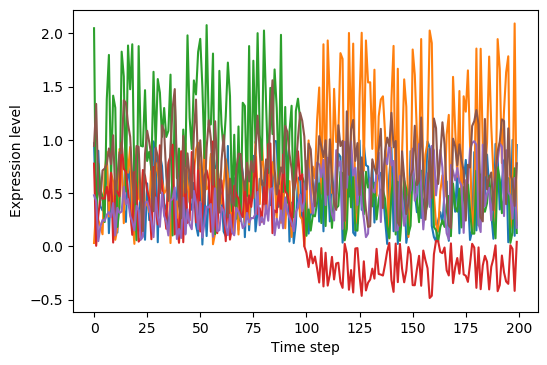

In [9]:
plt.figure()
for i in range(6):
    plt.plot(data[:, i])
    plt.xlabel('Time step')
    plt.ylabel('Expression level')

In [10]:
adj = np.ones((nodes,nodes)) #- np.eye(nodes)
# plt.imshow(adj); plt.colorbar()

In [11]:
trX1=data[:-1, :]
trY1=data[1:, :]

In [12]:
trX1=trX1[:,:,None]
trY1=trY1[:,:,None]

In [13]:
mu_trX0, std_trX0 = np.mean(trX1, axis=0, keepdims=True), np.std(trX1, axis=0, keepdims=True)
mu_trY0, std_trY0 = np.mean(trY1, axis=0, keepdims=True), np.std(trY1, axis=0, keepdims=True)
# mu_teX0, std_teX0 = np.mean(teX0, axis=0), np.std(teX0, axis=0)
# mu_teY0, std_teY0 = np.mean(teY0, axis=0), np.std(teY0, axis=0)

In [14]:
def normalize_data(data, mu, std):
    res = (data-mu) / std
    return res

def unnormalize_data(data, mu, std):
    res = data * std.reshape(1,-1) + mu.reshape(1,-1)
    return res

In [15]:
trX=trX1
trY=trY1

In [16]:
if inc:
    trYY = trY - trX
else:
    trYY = trY

In [17]:
Z = np.stack([kmeans2(trX[:,i], M, minit='points')[0] for i in range(nodes)],axis=1)  # (M=s2=10, n, d_in=5)
print('inducing points Z: {}'.format(Z.shape))

inducing points Z: (5, 6, 1)


In [18]:
# build model
# adj_identity = np.identity(adj.shape[0])  # without nb information
adj = adj.astype('float64')
input_adj = adj # adj  / np.identity(adj.shape[0]) /  np.ones_like(adj)

# Model

In [19]:
trX.shape

(199, 6, 1)

In [20]:
trY.shape

(199, 6, 1)

In [21]:
time_vec = np.arange(trX.shape[0])

In [22]:
with gpflow.defer_build():
    m_dgpg = DGPG(trX, trYY, Z, time_vec, [1], Gaussian(), input_adj,
                  agg_op_name='concat3d', ARD=True,
                  is_Z_forward=True, mean_trainable=True, out_mf0=True,
                  num_samples=1, minibatch_size=1,
                  #kern_type='Matern32', 
                  #kern_type='RBF', 
                  kern_type='Poly1', 
                  #wfunc='logi'
                  wfunc='krbf'
                 )
    # m_sgp = SVGP(X, Y, kernels, Gaussian(), Z=Z, minibatch_size=minibatch_size, whiten=False)
m_dgpg.compile()
model = m_dgpg

input-output dim (1(agg:6)->1)
2
func __init__ consumed 0.3s
Tensor("DGPG/strided_slice:0", shape=(), dtype=int32) Tensor("DGPG/strided_slice_1:0", shape=(), dtype=int32) Tensor("DGPG/strided_slice_2:0", shape=(), dtype=int32)


In [23]:
%%time

session = m_dgpg.enquire_session()
optimiser = gpflow.train.AdamOptimizer(0.005)
# optimiser = gpflow.train.ScipyOptimizer()
global_step = mon.create_global_step(session)


CPU times: user 119 ms, sys: 3.46 ms, total: 123 ms
Wall time: 121 ms


In [24]:
model.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
DGPG/layers/0/feature/Z,Parameter,None,(none),True,"(5, 6, 6)",True,"[[[0.13647742692605103, 0.11396189179495915, 0..."
DGPG/layers/0/kern/lengthscales,Parameter,None,+ve,True,"(6, 6)",True,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1...."
DGPG/layers/0/kern/variance,Parameter,None,+ve,True,"(6,)",True,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
DGPG/layers/0/q_mu,Parameter,None,(none),True,"(6, 5, 1)",True,"[[[0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], ..."
DGPG/layers/0/q_sqrt,Parameter,None,LoTri_3d->matrix,True,"(6, 1, 5, 5)",True,[[[[0.91990523 0. 0. 0. ...
DGPG/likelihood/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


In [25]:
Zcp = model.layers[0].feature.Z.value.copy()

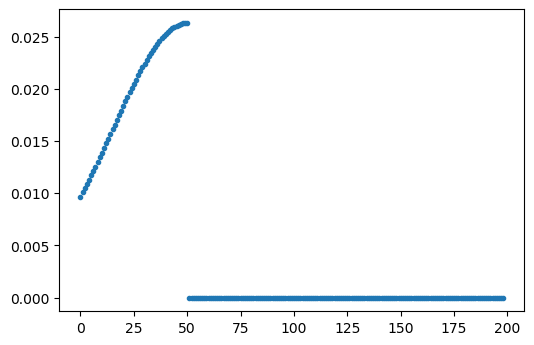

In [26]:
model.X.update_cur_n(50,cc=cc)

plt.plot(model.X.wpdf,'.')

# Training

In [27]:
def rmse(v1, v2):
    return np.sqrt(np.mean((v1.reshape(-1)-v2.reshape(-1))**2))

In [28]:
model.X.update_cur_n(0,cc=cc,loc=loc)
model.Y.update_cur_n(0,cc=cc,loc=loc)

In [29]:
pred_res = []

In [30]:
maxiter=12000

exp_path="./exp/tmp-cc%d" % int(cc)
#exp_path="./exp/temp"

print_task = mon.PrintTimingsTask()\
    .with_name('print')\
    .with_condition(mon.PeriodicIterationCondition(10))\

checkpoint_task = mon.CheckpointTask(checkpoint_dir=exp_path)\
        .with_name('checkpoint')\
        .with_condition(mon.PeriodicIterationCondition(15))\

In [31]:
with mon.LogdirWriter(exp_path) as writer:
    tensorboard_task = mon.ModelToTensorBoardTask(writer, model)\
        .with_name('tensorboard')\
        .with_condition(mon.PeriodicIterationCondition(100))\
        .with_exit_condition(True)
    monitor_tasks = [] # [print_task, tensorboard_task]

    with mon.Monitor(monitor_tasks, session, global_step, print_summary=True) as monitor:
        model.layers[0].feature.Z.assign(Zcp.copy())
        model.layers[0].kern.lengthscales.assign(np.ones((nodes, nodes)))
        optimiser.minimize(model, step_callback=monitor, global_step=global_step, maxiter=maxiter)
        #optimiser.minimize(model, step_callback=monitor, maxiter=maxiter)

Tasks execution time summary:


In [32]:
trX[1].reshape(1, nodes).shape

(1, 6)

In [33]:
teX = trX[0].reshape(1, nodes)

S=100
m, v = model.predict_y(teX, S)
pred = np.mean(m, axis=0)
if inc:
    pred += teX

Tensor("autoflow/DGPG/predict_y/strided_slice:0", shape=(), dtype=int32) Tensor("autoflow/DGPG/predict_y/strided_slice_1:0", shape=(), dtype=int32) Tensor("autoflow/DGPG/predict_y/strided_slice_2:0", shape=(), dtype=int32)


In [34]:
pred_res.append(pred)

In [35]:
pred.reshape(-1)

array([0.26048885, 0.35650001, 0.10389217, 0.00460632, 0.42643153,
       1.33696799])

In [36]:
trY[0].reshape(-1)

array([0.26047601, 0.3565001 , 0.10389219, 0.00460614, 0.42582729,
       1.33696871])

In [37]:
rmse(pred, trY[0])

0.00024673968744455484

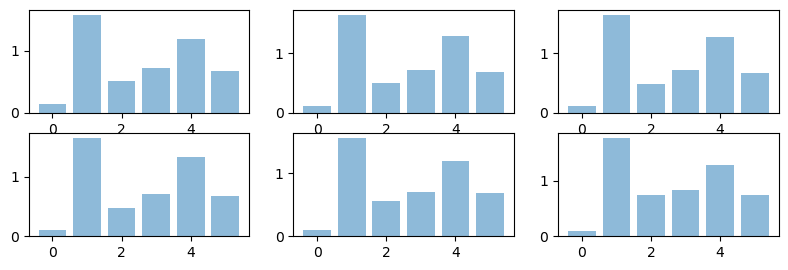

In [38]:
def plot_ard(nodeid=0):
    fig, axs = plt.subplots(2,3, figsize=(4, 3))
    objects = ['G%d' % (i+1) for i in range(nodes)]
    y_pos = np.arange(len(objects))
    for i in range(nodes):
        ls = model.layers[0].kern.lengthscales.value
        ls0 = ls[i]
        axs[i//3, i%3].bar(y_pos, ls0, align='center', alpha=0.5)

    plt.subplots_adjust(right=2)
    plt.show()
    
plot_ard()

In [39]:
nw = np.zeros((trX.shape[0], nodes, nodes))
nw[0, :, :] = model.layers[0].kern.lengthscales.value

STEP 1 - loss: 0.000245
STEP 2 - loss: 0.001257
STEP 3 - loss: 0.000355
STEP 4 - loss: 0.002154
STEP 5 - loss: 0.023927
STEP 6 - loss: 0.010172
STEP 7 - loss: 0.025603
STEP 8 - loss: 0.104607
STEP 9 - loss: 0.011699
STEP 10 - loss: 0.062389


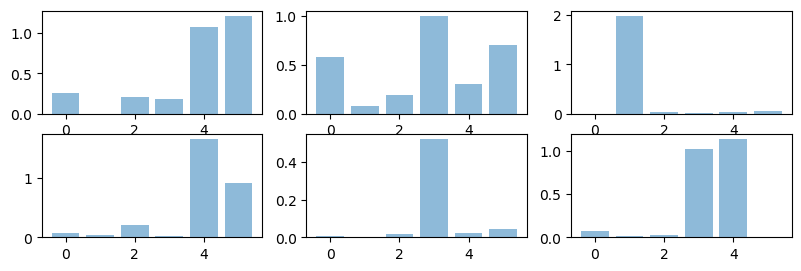

STEP 11 - loss: 0.060609
STEP 12 - loss: 0.150592
STEP 13 - loss: 0.107851
STEP 14 - loss: 0.152131
STEP 15 - loss: 0.069272
STEP 16 - loss: 0.180572
STEP 17 - loss: 0.094774
STEP 18 - loss: 0.261812
STEP 19 - loss: 0.082657
STEP 20 - loss: 0.130950


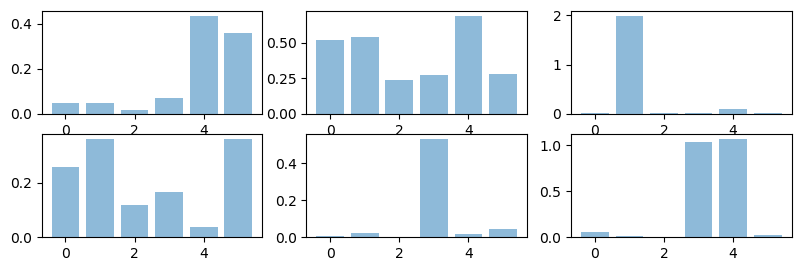

STEP 21 - loss: 0.101331
STEP 22 - loss: 0.219848
STEP 23 - loss: 0.098438
STEP 24 - loss: 0.072453
STEP 25 - loss: 0.191833
STEP 26 - loss: 0.155534
STEP 27 - loss: 0.227968
STEP 28 - loss: 0.223178
STEP 29 - loss: 0.137836
STEP 30 - loss: 0.201613


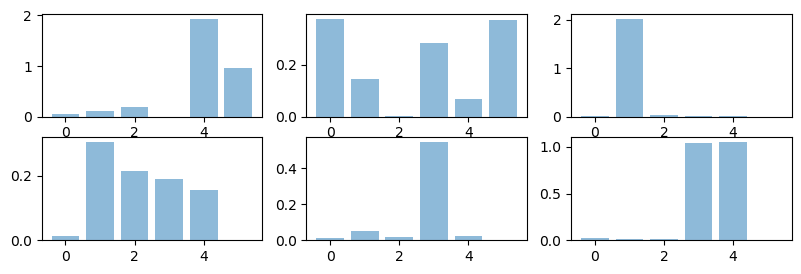

STEP 31 - loss: 0.094688
STEP 32 - loss: 0.099628
STEP 33 - loss: 0.156884
STEP 34 - loss: 0.249151
STEP 35 - loss: 0.090494
STEP 36 - loss: 0.141447
STEP 37 - loss: 0.141965
STEP 38 - loss: 0.088194
STEP 39 - loss: 0.153632
STEP 40 - loss: 0.215209


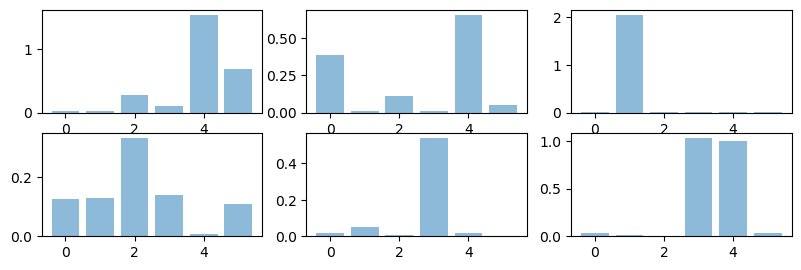

STEP 41 - loss: 0.153557
STEP 42 - loss: 0.150078
STEP 43 - loss: 0.131569
STEP 44 - loss: 0.234440
STEP 45 - loss: 0.220449
STEP 46 - loss: 0.168982
STEP 47 - loss: 0.185833
STEP 48 - loss: 0.246276
STEP 49 - loss: 0.194228
STEP 50 - loss: 0.206272


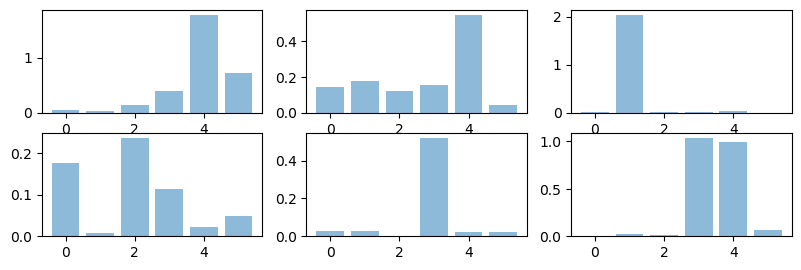

STEP 51 - loss: 0.231661
STEP 52 - loss: 0.137037
STEP 53 - loss: 0.074833
STEP 54 - loss: 0.172553
STEP 55 - loss: 0.351882
STEP 56 - loss: 0.182343
STEP 57 - loss: 0.193663
STEP 58 - loss: 0.099203
STEP 59 - loss: 0.070043
STEP 60 - loss: 0.100527


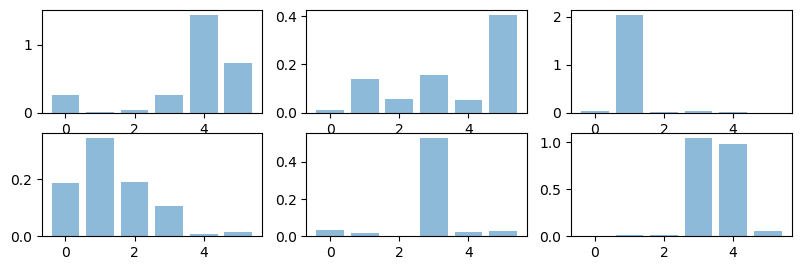

STEP 61 - loss: 0.198961
STEP 62 - loss: 0.224610
STEP 63 - loss: 0.211155
STEP 64 - loss: 0.175291
STEP 65 - loss: 0.193010
STEP 66 - loss: 0.125094
STEP 67 - loss: 0.148364
STEP 68 - loss: 0.182286
STEP 69 - loss: 0.113319
STEP 70 - loss: 0.193898


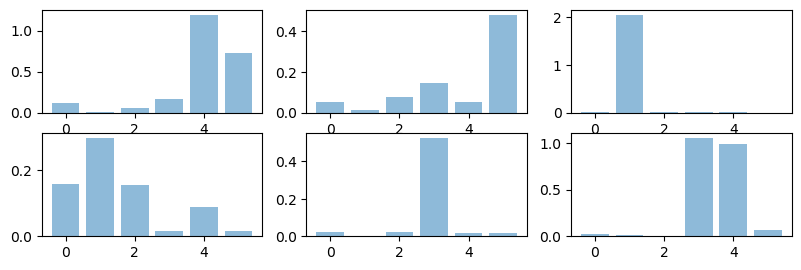

STEP 71 - loss: 0.174855
STEP 72 - loss: 0.117307
STEP 73 - loss: 0.099034
STEP 74 - loss: 0.165782
STEP 75 - loss: 0.210481
STEP 76 - loss: 0.131416
STEP 77 - loss: 0.174911
STEP 78 - loss: 0.149676
STEP 79 - loss: 0.137667
STEP 80 - loss: 0.159193


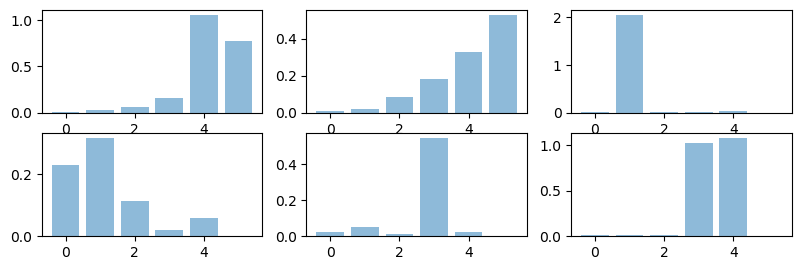

STEP 81 - loss: 0.272289
STEP 82 - loss: 0.170802
STEP 83 - loss: 0.120103
STEP 84 - loss: 0.107612
STEP 85 - loss: 0.233556
STEP 86 - loss: 0.217544
STEP 87 - loss: 0.092118
STEP 88 - loss: 0.175605
STEP 89 - loss: 0.186986
STEP 90 - loss: 0.084087


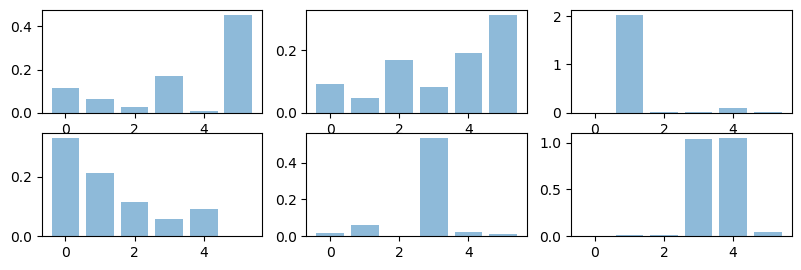

STEP 91 - loss: 0.247211
STEP 92 - loss: 0.168491
STEP 93 - loss: 0.181865
STEP 94 - loss: 0.246517
STEP 95 - loss: 0.191615
STEP 96 - loss: 0.157885
STEP 97 - loss: 0.213197
STEP 98 - loss: 0.205620
STEP 99 - loss: 0.275929
STEP 100 - loss: 0.197164


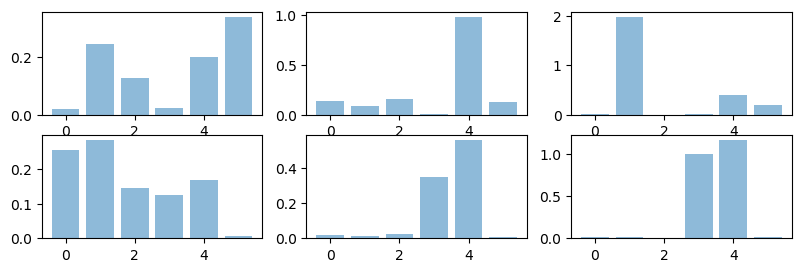

STEP 101 - loss: 0.475424
STEP 102 - loss: 0.146837
STEP 103 - loss: 0.355454
STEP 104 - loss: 0.301932
STEP 105 - loss: 0.197633
STEP 106 - loss: 0.364565
STEP 107 - loss: 0.406136
STEP 108 - loss: 0.347777
STEP 109 - loss: 0.414944
STEP 110 - loss: 0.198287


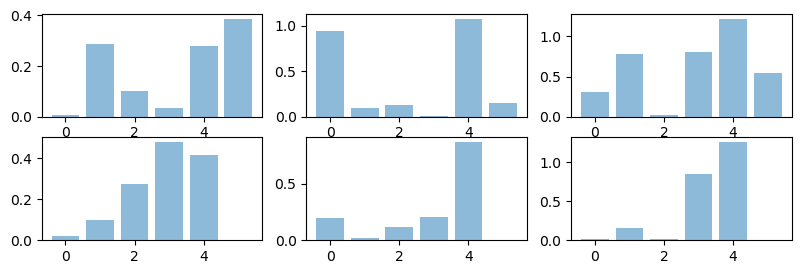

STEP 111 - loss: 0.244880
STEP 112 - loss: 0.281696
STEP 113 - loss: 0.350018
STEP 114 - loss: 0.216050
STEP 115 - loss: 0.213211
STEP 116 - loss: 0.377526
STEP 117 - loss: 0.287903
STEP 118 - loss: 0.211988
STEP 119 - loss: 0.189070
STEP 120 - loss: 0.172138


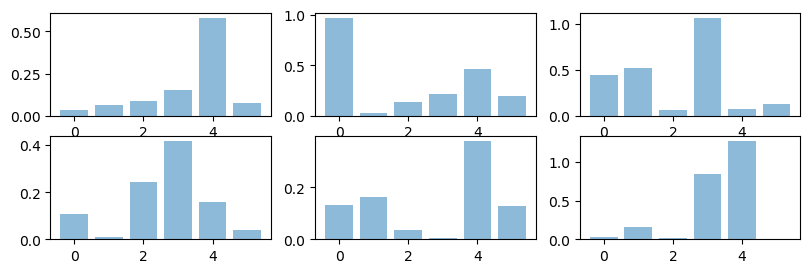

STEP 121 - loss: 0.237754
STEP 122 - loss: 0.181114
STEP 123 - loss: 0.156431
STEP 124 - loss: 0.335630
STEP 125 - loss: 0.109945
STEP 126 - loss: 0.239535
STEP 127 - loss: 0.194861
STEP 128 - loss: 0.164400
STEP 129 - loss: 0.155342
STEP 130 - loss: 0.109688


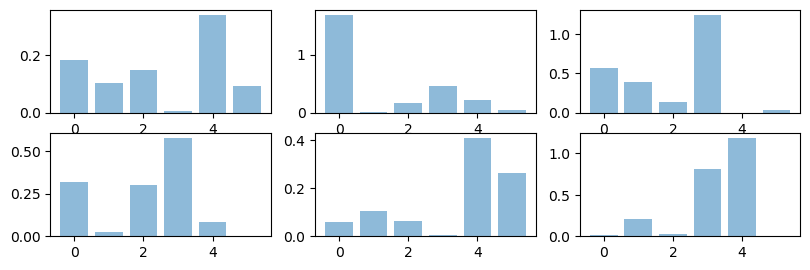

STEP 131 - loss: 0.126215
STEP 132 - loss: 0.180727
STEP 133 - loss: 0.187587
STEP 134 - loss: 0.191819
STEP 135 - loss: 0.072614
STEP 136 - loss: 0.171935
STEP 137 - loss: 0.230506
STEP 138 - loss: 0.156822
STEP 139 - loss: 0.206288
STEP 140 - loss: 0.214900


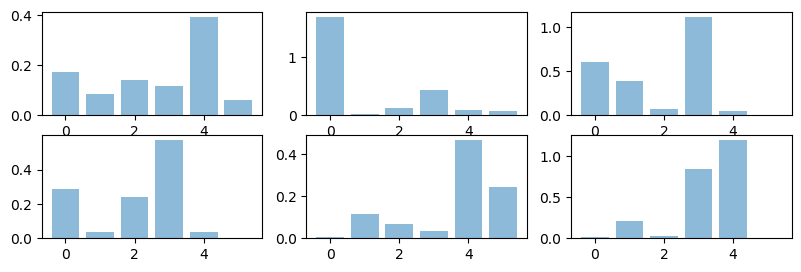

STEP 141 - loss: 0.244464
STEP 142 - loss: 0.130134
STEP 143 - loss: 0.181910
STEP 144 - loss: 0.154839
STEP 145 - loss: 0.150418
STEP 146 - loss: 0.128814
STEP 147 - loss: 0.082142
STEP 148 - loss: 0.244964
STEP 149 - loss: 0.249617
STEP 150 - loss: 0.169944


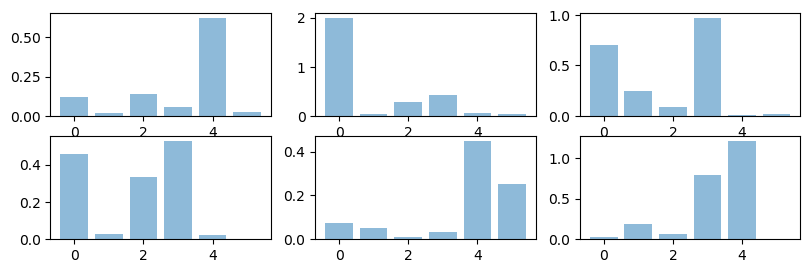

STEP 151 - loss: 0.056694
STEP 152 - loss: 0.296432
STEP 153 - loss: 0.179733
STEP 154 - loss: 0.197274
STEP 155 - loss: 0.130414
STEP 156 - loss: 0.278187
STEP 157 - loss: 0.154119
STEP 158 - loss: 0.177769
STEP 159 - loss: 0.206088
STEP 160 - loss: 0.177174


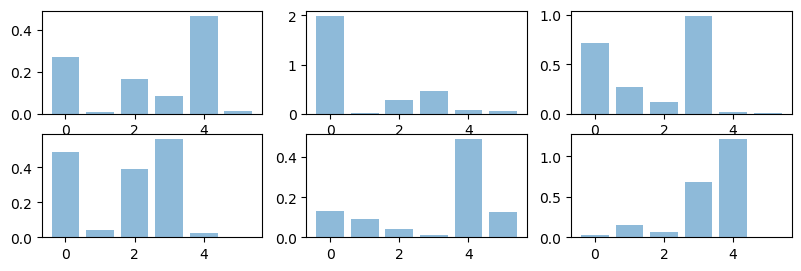

STEP 161 - loss: 0.110550
STEP 162 - loss: 0.174273
STEP 163 - loss: 0.108322
STEP 164 - loss: 0.119799
STEP 165 - loss: 0.143517
STEP 166 - loss: 0.123615
STEP 167 - loss: 0.328329
STEP 168 - loss: 0.071365
STEP 169 - loss: 0.070169
STEP 170 - loss: 0.137885


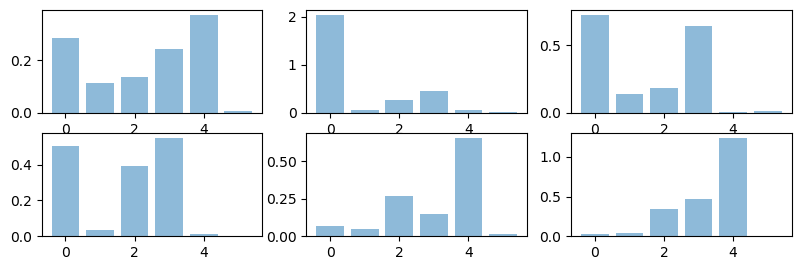

STEP 171 - loss: 0.145279
STEP 172 - loss: 0.099527
STEP 173 - loss: 0.134947
STEP 174 - loss: 0.187079
STEP 175 - loss: 0.028309
STEP 176 - loss: 0.203425
STEP 177 - loss: 0.112315
STEP 178 - loss: 0.200291
STEP 179 - loss: 0.155991
STEP 180 - loss: 0.266639


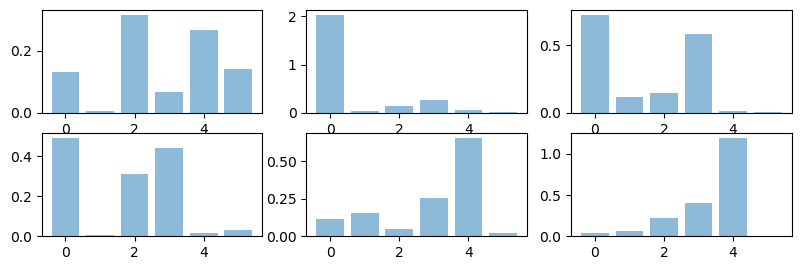

STEP 181 - loss: 0.073085
STEP 182 - loss: 0.193751
STEP 183 - loss: 0.149906
STEP 184 - loss: 0.160702
STEP 185 - loss: 0.054614
STEP 186 - loss: 0.155617
STEP 187 - loss: 0.140171
STEP 188 - loss: 0.298317
STEP 189 - loss: 0.167892
STEP 190 - loss: 0.109524


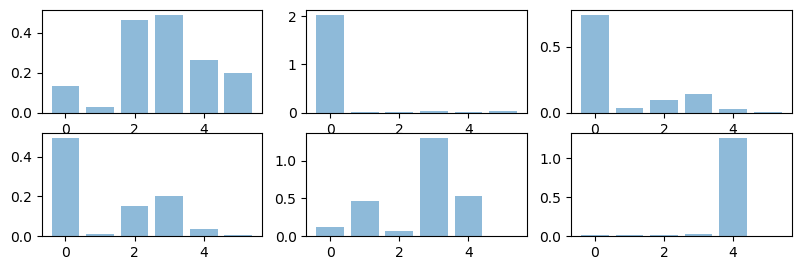

STEP 191 - loss: 0.047505
STEP 192 - loss: 0.194527
STEP 193 - loss: 0.187987
STEP 194 - loss: 0.213884
STEP 195 - loss: 0.141598
STEP 196 - loss: 0.264786
STEP 197 - loss: 0.142894
STEP 198 - loss: 0.257059


In [40]:
maxiter=12000
plot_interv = 10

# for cur_n in range(1, trX.shape[0]-1):
for cur_n in range(1, trX.shape[0]):
    model.X.update_cur_n(cur_n,cc=cc,loc=loc)
    model.Y.update_cur_n(cur_n,cc=cc,loc=loc)
    with mon.LogdirWriter(exp_path) as writer:
        tensorboard_task = mon.ModelToTensorBoardTask(writer, model)\
            .with_name('tensorboard')\
            .with_condition(mon.PeriodicIterationCondition(100))\
            .with_exit_condition(True)
        monitor_tasks = [tensorboard_task] # [print_task, tensorboard_task]

        with mon.Monitor(monitor_tasks, session) as monitor:
            #optimiser.minimize(model, step_callback=monitor, global_step=global_step, maxiter=maxiter)
            model.layers[0].feature.Z.assign(Zcp.copy())
            model.layers[0].kern.lengthscales.assign(np.ones((nodes, nodes)))
            optimiser.minimize(model, step_callback=monitor, maxiter=maxiter)
            nw[cur_n, :, :] = model.layers[0].kern.lengthscales.value
            
    teX = trX[cur_n].reshape(1, nodes)

    S=100
    m, v = model.predict_y(teX, S)
    pred = np.mean(m, axis=0)
    if inc:
        pred += teX
    
    pred_res.append(pred)
    print('STEP %d - loss: %f' % (cur_n, rmse(pred, trY[cur_n])))
    
    if cur_n % plot_interv == 0: plot_ard()

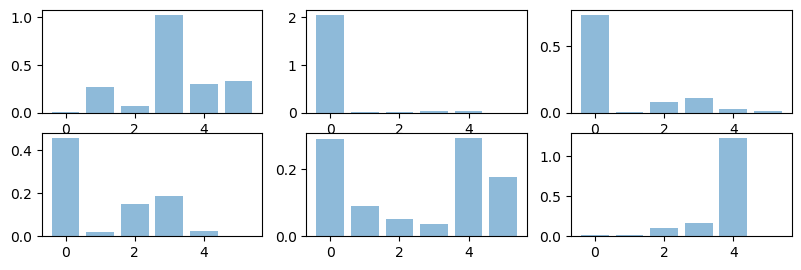

In [41]:
plot_ard()

# Extract Relation

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm,
                target_names,
                title='Confusion matrix',
                cmap=None,
                normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap=cmap)
    #plt.title(title)
    plt.colorbar()

#     if target_names is not None:
#         tick_marks = np.arange(len(target_names))
#         plt.xticks(tick_marks, target_names, rotation=45)
#         plt.yticks(tick_marks, target_names, horizontalalignment="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [43]:
def row_norm0(ls_vec):
    #res = ls_vec / sum(ls_vec)
    #res = ls_vec**0.5 / sum(ls_vec**0.5)
    res = ls_vec
    return res

def row_norm(lss):
    tmp = np.zeros(lss.shape)
    for i in range(lss.shape[0]):
        tmp[i] = row_norm0(lss[i])
    return tmp

def get_thresh(lss, sparsity=0.1):
    tmp = row_norm(lss)
    tmp_srt = np.sort(tmp.reshape(-1))[::-1]
    idx = int(lss.shape[0]*lss.shape[1]*sparsity)+1
    th = tmp_srt[idx]
    return th

def ext_rel(ls_vec, th):
    norm_ls = row_norm0(ls_vec)
    #print(norm_ls)
    res = np.where(norm_ls > th)
    return res[0]

def print_connect(lss, th=0.6):
    for j in range(nodes):
        i = ext_rel(lss[j], th)
        print(str(i) + ' -> ' + str(j))

In [44]:
conn1 = [(1,2), (3,4), (3,5), (4,5)]
conn2 = [(0,1), (0,2), (0,3), (4,5)]

conn_mat1 = np.zeros((nodes, nodes))
conn_mat2 = np.zeros((nodes, nodes))

for (i, j) in conn1: conn_mat1[j, i] = 1
for (i, j) in conn2: conn_mat2[j, i] = 1
    
print(conn_mat1)
print(conn_mat2)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [56]:
def evaluate(th=0.25):
    precision, recall, f1 = [], [], []
    all_gt, all_pred = [], []

    for ts in range(0, 199):
        if ts < 100:
            gt = conn_mat1.astype(int)
        else:
            gt = conn_mat2.astype(int)
        pred = (row_norm(nw[ts]) > th).astype(int)
        all_gt += list(gt.reshape(-1)).copy()
        all_pred += list(pred.reshape(-1)).copy()
        stat = classification_report(gt.reshape(-1), pred.reshape(-1), digits=4, 
                                     target_names=['0', '1'], output_dict=True)
        precision.append(stat['1']['precision'])
        recall.append(stat['1']['recall'])
        f1.append(stat['1']['f1-score'])
    return (precision, recall, f1, all_gt, all_pred)
#         if ts % 20 == 0: 
#             print('timestep: %d, thresh: %.2f' % (ts, th))
#             print(gt.reshape(-1))
#             print(pred.reshape(-1))
#             print_connect(nw[ts], th=th)
#             cm = confusion_matrix(gt.reshape(-1), pred.reshape(-1))
#             #plot_confusion_matrix(cm, ['0', '1'], normalize = False)
#             print(classification_report(gt.reshape(-1), pred.reshape(-1), digits=4, target_names=['0', '1']))

In [74]:
allres = {}

for th in np.arange(0.1, 2.01, 0.1):
    allres['%.2f'%th] = evaluate(th)

In [75]:
def plot_data(th):
    (Precision, Recall, F1, all_gt, all_pred) = allres['%.2f'%th]
    for m in 'Precision Recall F1'.split():
        plt.figure()
        plt.plot(eval(m))
        plt.xlabel('Time step')
        plt.ylabel(m)

In [76]:
def overall_report(th):
    (Precision, Recall, F1, all_gt, all_pred) = allres['%.2f'%th]
    cm = confusion_matrix(all_gt, all_pred)
    # plot_confusion_matrix(cm, ['0', '1'], normalize = False)
    print(classification_report(all_gt, all_pred, digits=4, target_names=['0', '1']))

In [77]:
for th in np.arange(0.1, 2.01, 0.1):
    print('threshold: %.2f' % th)
    overall_report(th)
    print()

threshold: 0.10
              precision    recall  f1-score   support

           0     0.9965    0.5741    0.7285      6368
           1     0.2240    0.9837    0.3649       796

    accuracy                         0.6196      7164
   macro avg     0.6102    0.7789    0.5467      7164
weighted avg     0.9106    0.6196    0.6881      7164


threshold: 0.20
              precision    recall  f1-score   support

           0     0.9939    0.7186    0.8341      6368
           1     0.3000    0.9648    0.4577       796

    accuracy                         0.7460      7164
   macro avg     0.6470    0.8417    0.6459      7164
weighted avg     0.9168    0.7460    0.7923      7164


threshold: 0.30
              precision    recall  f1-score   support

           0     0.9915    0.8029    0.8873      6368
           1     0.3747    0.9447    0.5366       796

    accuracy                         0.8187      7164
   macro avg     0.6831    0.8738    0.7119      7164
weighted avg     0.9229 

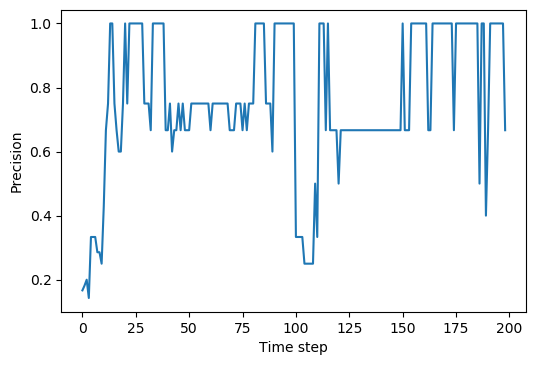

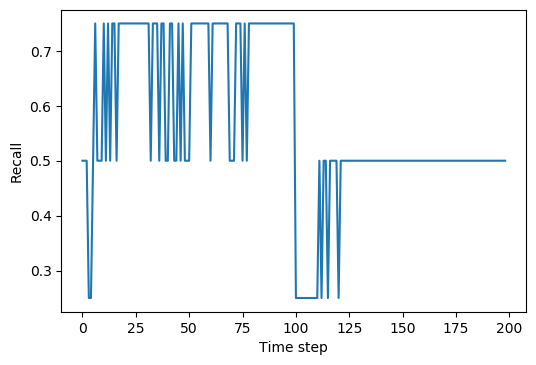

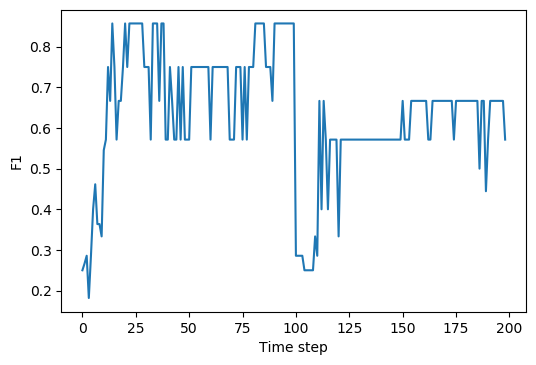

In [81]:
plot_data(1.0)